## ML Modeling 



In [1]:
%pip install matplotlib_inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats

import plotly.express as px
import plotly.io as pio

from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge 

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

#Random Search 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import uniform



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
! pip install xgboost

from xgboost import XGBRegressor


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Load the data

In [3]:
df_encoded = pd.read_csv('df_encoded.csv')

In [4]:
df_encoded.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'absences %', 'absences_category', 'average_grade',
       'grade_category', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other'],
      dtype='object')

## Train_test_split

In [5]:
X = df_encoded.drop(['G1','G2','G3','failures','absences %','average_grade','grade_category','absences_category'], axis=1) #dropping target variables (Semesters 1-3 grades) also dropping (failures) since its obvious that if they failed they would have low grades

y = df_encoded['average_grade']
#y = df_encoded[['G1','G2','G3']] #my target variables 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

## Modeling (Predicting Grades using Linear Regression)

### Model 1. Linear Regdression

In [6]:
#Initializing the model 

lr = LinearRegression()

#Fitting the model
lr.fit(X_train, y_train)

#Making predictions on test data
y_pred = lr.predict(X_test)

#Check model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


#Print results 

print('Mean Squared Error', mse)
print('R2 score', r2)

Mean Squared Error 0.9019538843887447
R2 score 0.13179398075961457


### Reflection on Model 1:
The mse score suggests that the model is off by around .90 points which is decent since grades after being scaled range from -2.53-2.34. R2 score of .13 suggests that the model can only explain around 13% of the variance in the data which is not very good. Improvements can be made!

### Linear Regression Model 1.2: Ridge

In [ ]:

#Initialize model
ridge = Ridge(alpha=1.0)

#Fit model
ridge.fit(X_train,y_train)

#Predict
y_pred_ridge = ridge.predict(X_test)

#Check scores
mse_ridge = mean_squared_error(y_test,y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print('Ridge Mean Squared Error', mse_ridge)
print('R^2 Ridge Score', r2_ridge)

Ridge Mean Squared Error 0.8975084450984269
R^2 Ridge Score 0.1360730877259727


### Model 2. Random Forest Regressor

In [8]:
#initialize the random forest regressor

rf = RandomForestRegressor(n_estimators=200, max_depth=10,random_state=22)


#Train model
rf.fit(X_train, y_train)

#Make prediction
y_pred_rf = rf.predict(X_test)

#Check model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Rf Mean Squared Error', mse_rf)
print('Rf R2 Score', r2_rf)

Rf Mean Squared Error 0.7697483497868801
Rf R2 Score 0.2590528605148912


### Reflection on Random Forest Regressor
MSE score of .76 is an improvement original model. Additionally R^2 score of 25% is a significant improvement from the linear models of 13%. This means that the model is doing a better job of capturing the relationships between features.

In [9]:
#Using cross validation 

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Mean R² from cross-validation:", np.mean(cv_scores))

Cross-validated R² scores: [ 0.05723899  0.15717387  0.10261397 -0.2413429   0.21119074]
Mean R² from cross-validation: 0.057374933548217766


### Reflection: 

Model is performing poorly!

### Hyperparameter tuning with RandomSearchCV on Random Forest Regressor

In [10]:
#Random Search 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform 

# Define the parameter distributions
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0, 1)  # Fraction of features to consider at each split
}


# Instantiate the random search model
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_distributions, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_squared_error',
    random_state=42
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"R2 score: {r2}")

# Feature importance
feature_importance = best_model.feature_importances_
for i, importance in enumerate(feature_importance):
    print(f"Feature {i+1} importance: {importance}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=61, max_features=0.9507143064099162, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.6s
[CV] END max_depth=61, max_features=0.9507143064099162, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.6s
[CV] END max_depth=61, max_features=0.9507143064099162, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.6s
[CV] END max_depth=92, max_features=0.09997491581800289, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   1.2s
[CV] END max_depth=92, max_features=0.09997491581800289, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   1.2s
[CV] END max_depth=92, max_features=0.09997491581800289, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   1.2s
[CV] END max_depth=33, max_features=0.6508884729488529, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   1

### Best parameters 


Best parameters: {'max_depth': 17, 'max_features': 0.8492234104941779, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 275}


Mean squared error: 0.7838837112265044


R2 score: 0.2454463933790052

### Hyperparameter tunning based on RandomSearch results

In [11]:
#Hyperparameter tuning to avoid overfitting based on GridSearchCV and RandomizedSearchCV


#initialize the random forest regressor

rf = RandomForestRegressor(n_estimators=216, max_depth=28, max_features= 0.7951861947687037, min_samples_leaf= 3, min_samples_split= 6, random_state=22)


#Train model
rf.fit(X_train, y_train)

#Make prediction
y_pred_rf = rf.predict(X_test)

#Check model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Rf Mean Squared Error', mse_rf)
print('Rf R2 Score', r2_rf)

Rf Mean Squared Error 0.7655234116608999
Rf R2 Score 0.2631197166761462


### Reflection: MSE of .76 and R squared of .26 are significant improvements. 

## Visualizing feature importance 

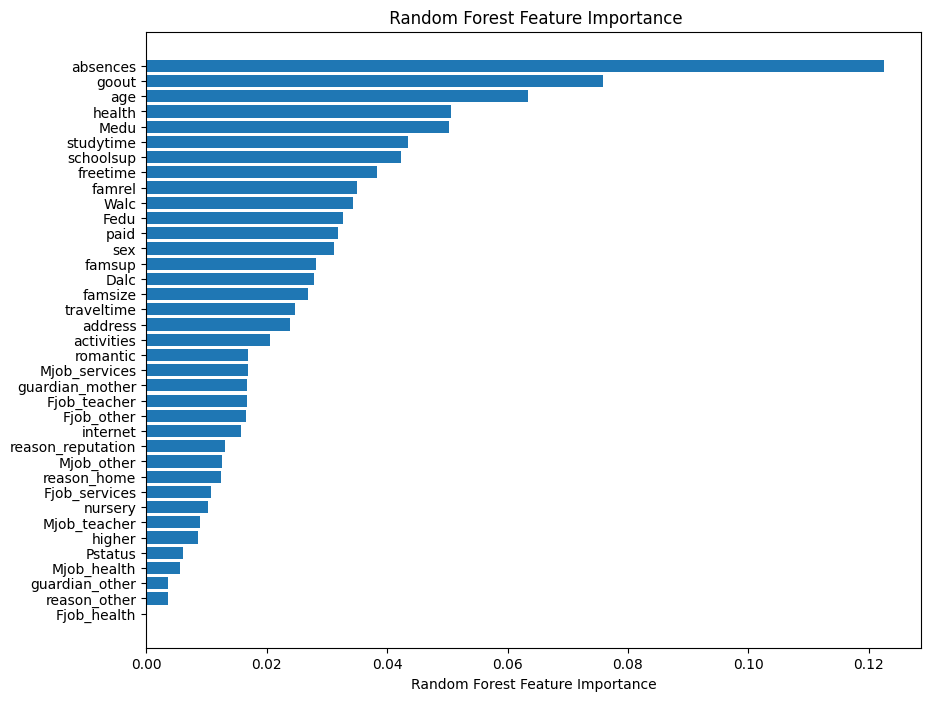

In [12]:
# Extract and plot feature importances
importances = rf.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx], fontsize=10)
plt.xlabel("Random Forest Feature Importance")

plt.title(' Random Forest Feature Importance')
plt.show()

### Reflection on feature importance:
Absences and going out are the two most important features for predicting grades. Age and health are also important. I wonder if there is a correlation between going out, drinking alochol and absences. This would warrant future investigation. 

### Model 3. Gradient Boosting Regressor (XGBoost)

In [13]:
! pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
#Initialize XGBoost

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=22)

#Train the model 
xgb.fit(X_train, y_train)

#Make prediction
y_pred_xgb = xgb.predict(X_test)

#Check model performance 

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print('XGBoost Mean Squared Error', mse_xgb)
print('XGBoost R2 Score', r2_xgb)

#learning rate= 0.1,

XGBoost Mean Squared Error 0.8704141188388042
XGBoost R2 Score 0.1621536419017654


In [15]:
#RandomSearch on XGBoost

# Define the hyperparameter grid for XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],       # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         # Step size shrinkage
    'max_depth': [3, 4, 5, 6, 8, 10],                # Maximum depth of a tree
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],          # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],   # Subsample ratio of columns for each tree
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],                # Minimum loss reduction to make a split
    'reg_alpha': [0, 0.1, 0.5, 1],                   # L1 regularization term
    'reg_lambda': [1, 1.5, 2, 3],                    # L2 regularization term
}

In [16]:
# Initialize XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=22)

In [17]:
# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,                      # Number of parameter combinations to try
    scoring='neg_mean_squared_error',# Metric to optimize
    cv=5,                           # 5-fold cross-validation
    verbose=1,                      # Show progress
    random_state=42,                # For reproducibility
    n_jobs=-1                       # Use all available cores
)

In [18]:
# Fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score (neg MSE): ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Best cross-validation score (neg MSE):  -0.8970670391023698


In [19]:
# Make predictions with the best estimator on the test set
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R^2 Score: {r2}")

Test Mean Squared Error: 0.8526481960851684
Test R^2 Score: 0.17925482782605406


## Classification Models

### Using classification models to predict if students will fail classes. Doing so will help set up intervention for low students and help inform teachers to increase academic rigor for high students. 

In [20]:
df_encoded.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'absences %', 'absences_category', 'average_grade',
       'grade_category', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other'],
      dtype='object')

In [21]:
df_encoded['failures'].head()

0    0.0
1    0.0
2    3.0
3    0.0
4    0.0
Name: failures, dtype: float64

In [22]:
#unbalanced

df_encoded['failures'].value_counts()

failures
0.0    311
1.0     50
2.0     15
3.0     14
Name: count, dtype: int64

In [23]:
X = df_encoded.drop(['G1','G2','G3','failures','absences %','average_grade', 'absences_category','grade_category'], axis=1) #dropping target variables (Semesters 1-3 grades) also dropping (failures) since its obvious that if they failed they would have low grades

y = df_encoded['failures']
#y = df_encoded[['G1','G2','G3']] #my target variables 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

### Logistic Regression Model

In [24]:
#Instantiate the model: I am using multi_class='multinomial' since my classification is multiclass. solver='lbfgs' is the optimization algorithm which works well on small-medium datasets such as mine.
logreg_model = LogisticRegression(multi_class='multinomial',solver='lbfgs', random_state=22)

# if I want to predict grade category (LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=22))

#fit the model
logreg_model.fit(X_train, y_train)

#predict
y_pred = logreg_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
#Check model accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7959183673469388
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91        82
         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         3

    accuracy                           0.80        98
   macro avg       0.22      0.24      0.23        98
weighted avg       0.73      0.80      0.76        98



In [26]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[78  1  1  2]
 [ 7  0  0  1]
 [ 3  2  0  0]
 [ 2  1  0  0]]


In [27]:
# Perform 5-fold cross-validation to check generalization
cross_val_scores = cross_val_score(logreg_model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cross_val_scores.mean()}")

Cross-Validation Accuracy: 0.746697837521917


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: Futu

### Hyperparameter tunning on LR Model 

In [28]:
# Hyperparameter grid
param_distributions = {
    'C': uniform(0.01, 100),  # C values between 0.01 and 100
    'penalty': ['l2'],  # Only L2 regularization since 'lbfgs' solver does not support L1
    'solver': ['lbfgs'],  # Solver choice
    'max_iter': [100, 200, 300]  # Number of iterations for convergence
}

In [29]:
# Initialize the RandomizedSearchCV with Logistic Regression
random_search = RandomizedSearchCV(
    LogisticRegression(multi_class='multinomial', random_state=22),
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',  # Optimize for accuracy
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=22,  # Ensure reproducibility
    n_jobs=-1  # Use all available cores
)

In [30]:
# Fit Randomized Search on training data

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(multi_class='multinomial',
                                                random_state=22),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1375a9d60>,
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs']},
                   random_state=22, scoring='accuracy', verbose=1)

In [31]:
#Print best parameters

print('Best Parameters', random_search.best_params_)

#Print best cross-val score

print('Best Cross-Validation Score:', random_search.best_score_)

Best Parameters {'C': 0.6240866346098228, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7535359438924606


In [32]:
# Evaluate the best model on the test set
best_logreg_model = random_search.best_estimator_
y_pred = best_logreg_model.predict(X_test)

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7959183673469388
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91        82
         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         3

    accuracy                           0.80        98
   macro avg       0.22      0.24      0.23        98
weighted avg       0.73      0.80      0.76        98

Confusion Matrix:
[[78  1  1  2]
 [ 7  0  0  1]
 [ 3  2  0  0]
 [ 2  1  0  0]]


In [33]:
#Model with best params 

#Best Parameters {'C': 0.6240866346098228, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}

#Best Params model 
Best_logreg_model = LogisticRegression(multi_class='multinomial', C=0.6240866346098228, max_iter=300, penalty='l2',solver='lbfgs', random_state=22)


#fit the model
Best_logreg_model.fit(X_train, y_train)

#predict
y_pred = logreg_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [34]:
# Perform 5-fold cross-validation to check generalization
cross_val_scores = cross_val_score(Best_logreg_model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cross_val_scores.mean()}")

Cross-Validation Accuracy: 0.7535359438924606


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

In [35]:
# Evaluate the best model from RandomizedSearchCV on the test set
best_logreg_model = random_search.best_estimator_

# Make predictions on the test set
y_pred_test = best_logreg_model.predict(X_test)

# Calculate Test Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Test Accuracy: 0.7959183673469388
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91        82
         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         3

    accuracy                           0.80        98
   macro avg       0.22      0.24      0.23        98
weighted avg       0.73      0.80      0.76        98

Confusion Matrix:
[[78  1  1  2]
 [ 7  0  0  1]
 [ 3  2  0  0]
 [ 2  1  0  0]]


                    Coefficient    Importance
Mjob_teacher       7.979728e-17  7.979728e-17
Medu              -8.326673e-17  8.326673e-17
activities        -1.249001e-16  1.249001e-16
reason_home       -1.387779e-16  1.387779e-16
Fjob_teacher      -1.526557e-16  1.526557e-16
age                1.908196e-16  1.908196e-16
Fjob_services      2.220446e-16  2.220446e-16
Pstatus           -2.220446e-16  2.220446e-16
Mjob_services      2.359224e-16  2.359224e-16
address           -2.636780e-16  2.636780e-16
Mjob_other         2.775558e-16  2.775558e-16
schoolsup         -2.844947e-16  2.844947e-16
studytime          2.914335e-16  2.914335e-16
Fjob_health       -2.949030e-16  2.949030e-16
reason_other      -3.573530e-16  3.573530e-16
romantic          -3.885781e-16  3.885781e-16
nursery            4.024558e-16  4.024558e-16
sex                4.232725e-16  4.232725e-16
famsize            4.302114e-16  4.302114e-16
guardian_mother   -4.440892e-16  4.440892e-16
famsup             4.579670e-16  4

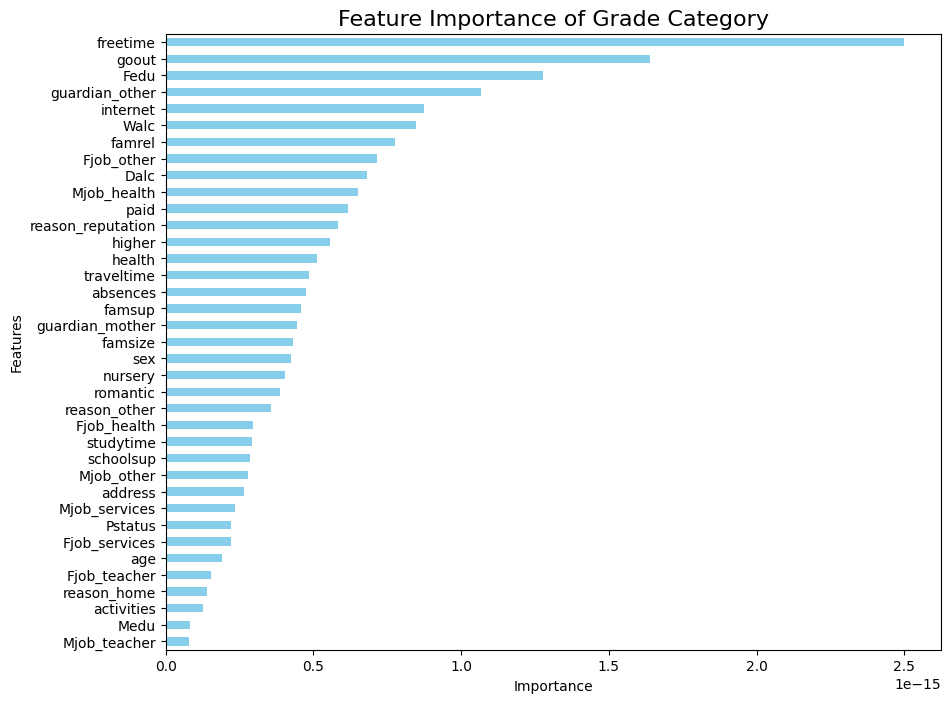

In [36]:
# Check the shape of coefficients
coefficients = best_logreg_model.coef_

# For multiclass, compute the mean or sum of absolute coefficients across all classes
coefficients_mean = coefficients.mean(axis=0)  # Take the mean across classes

# Flatten if necessary
coefficients_mean = coefficients_mean.flatten()

# Create a DataFrame for visualization
coeff_df = pd.DataFrame(coefficients_mean, index=feature_names, columns=['Coefficient'])

# Calculate importance as the absolute value of the coefficients
coeff_df['Importance'] = coeff_df['Coefficient'].abs()

# Sort by importance
coeff_df = coeff_df.sort_values(by='Importance', ascending=True)

# Print or visualize the DataFrame
print(coeff_df)

# Plot feature importances
plt.figure(figsize=(10, 8))
coeff_df['Importance'].plot(kind='barh', color='skyblue')
plt.title('Feature Importance of Grade Category', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


### Observations:
The most important feature in predicting if a student will fail one or more classes is free time and going out with peers. 

### Model 2 for Classification: Random Forest Classifier 


In [37]:
from sklearn.ensemble import RandomForestClassifier

Test Accuracy: 0.8367346938775511
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        82
         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         3

    accuracy                           0.84        98
   macro avg       0.21      0.25      0.23        98
weighted avg       0.71      0.84      0.77        98



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

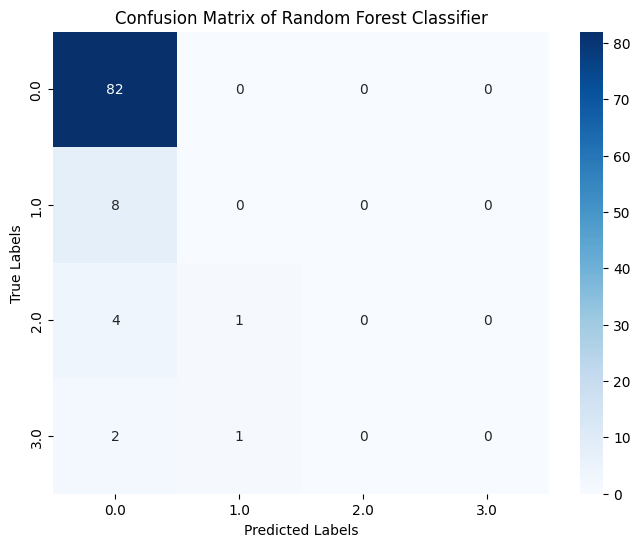

In [38]:
# Initialize the Random Forest Classifier with some basic parameters
# You can adjust n_estimators (number of trees) and max_depth (depth of each tree) for tuning
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=22)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix of Random Forest Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Hyperparameter tuning

In [39]:
! pip install scikit-optimize



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [40]:
from skopt import BayesSearchCV

In [41]:
# Define the parameter search space
param_space = {
    'n_estimators': (50, 300),                   # Number of trees in the forest
    'max_depth': (5, 20),                        # Depth of each tree
    'min_samples_split': (2, 10),                # Minimum samples required to split an internal node
    'min_samples_leaf': (1, 4),                  # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]     # Number of features to consider at each split
}

# Set up the Bayesian Optimization with cross-validation (cv=5)
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=22),
    search_spaces=param_space,
    n_iter=32,                  # Number of iterations (try 32 to start, then adjust as needed)
    cv=5,                       # 5-fold cross-validation
    scoring='accuracy',         # Scoring metric (you can adjust based on goals)
    n_jobs=-1,                  # Use all processors
    verbose=2,
    random_state=22
)

# Fit the BayesSearchCV
bayes_search.fit(X_train, y_train)

# Retrieve and print the best parameters and accuracy score
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

# Use the best model to predict on the test set
best_rf_model = bayes_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=77; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=77; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=77; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=77; total time=   0.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=77; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=291; total time=   0.7s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=291; total time=   0.7s
[CV] END max_depth=8, max_features=sqrt, min_samp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END max_depth=6, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=102; total time=   0.2s
[CV] END max_depth=6, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=102; total time=   0.2s
[CV] END max_depth=6, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=102; total time=   0.2s
[CV] END max_depth=6, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=102; total time=   0.2s
[CV] END max_depth=6, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=102; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=250; total time=   0.4s
[CV] END max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=250; total time=   0.4s
[CV] END max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=250; total

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Test Accuracy: 0.8367346938775511
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        82
         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         3

    accuracy                           0.84        98
   macro avg       0.21      0.25      0.23        98
weighted avg       0.71      0.84      0.77        98



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

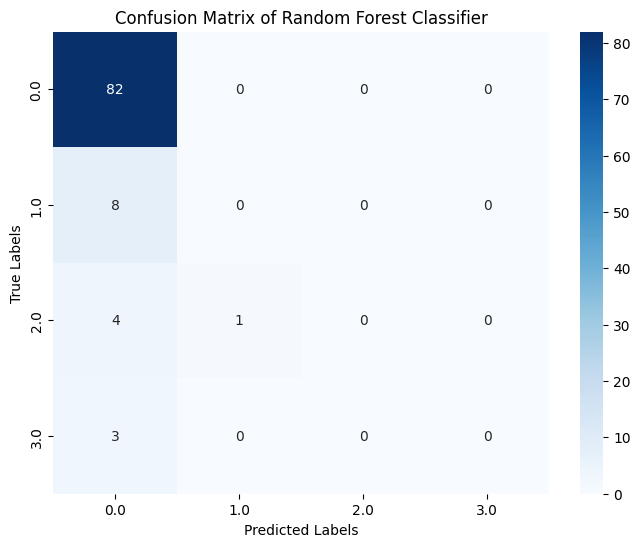

In [42]:
# Initialize the Random Forest Classifier with some basic parameters
# You can adjust n_estimators (number of trees) and max_depth (depth of each tree) for tuning
best_rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10,random_state=22)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.title("Confusion Matrix of Random Forest Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Best Parameters: OrderedDict({'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50})

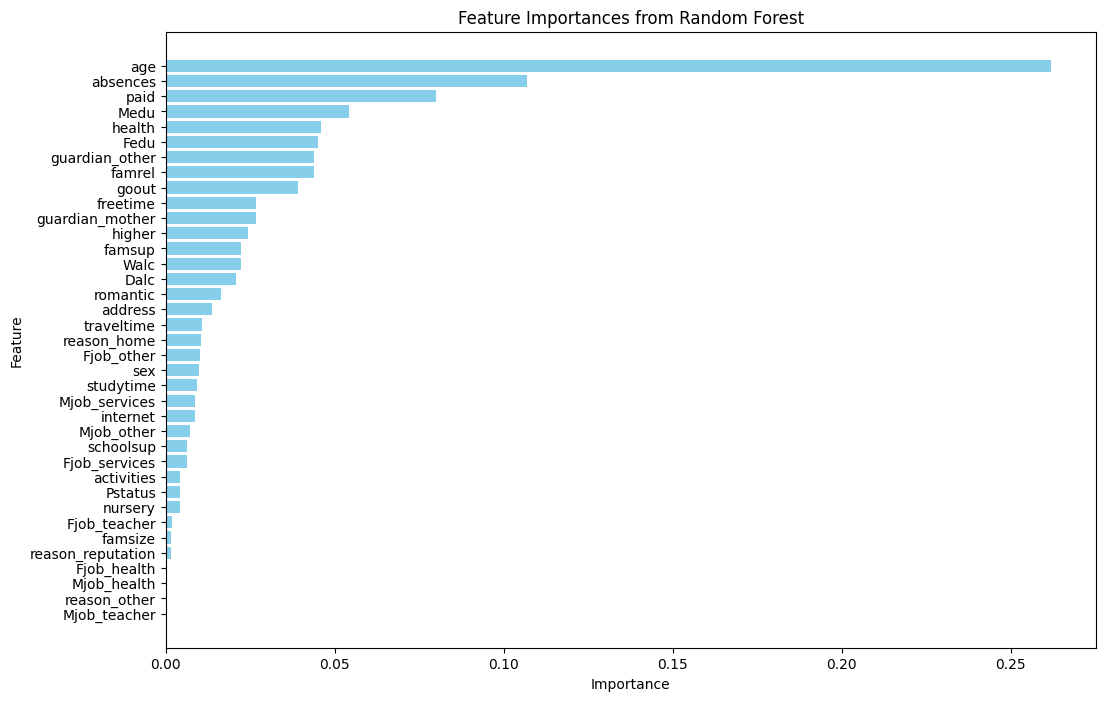

In [43]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Conclusion 